# PPS Pax prediction with respect to time

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
import warnings
import joblib
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import f1_score, mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Datasets/FlightsByDay-SRQ-2025_07_21_09_49_46.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13279 entries, 0 to 13278
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Date                 13279 non-null  object
 1   Flight               13279 non-null  object
 2   Destination Airport  13279 non-null  object
 3   Airline              13279 non-null  object
 4   Boarded              13279 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 518.8+ KB


In [3]:
df

,Date,Flight,Destination Airport,Airline,Boarded
0,2023-09-14,AA2679,DFW,AA,130
1,2023-09-14,AA5521,CLT,AA,1
2,2023-09-14,G41150,PIT,G4,155
3,2023-09-14,G4183,ABE,G4,152
4,2023-09-14,G4218,AVL,G4,144
...,...,...,...,...,...
13274,2025-07-20,WN4605,MDW,WN,125
13275,2025-07-20,WN4606,STL,WN,75
13276,2025-07-20,XP306,HVN,XP,132
13277,2025-07-21,G41355,CAK,G4,7


## line graph

In [4]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

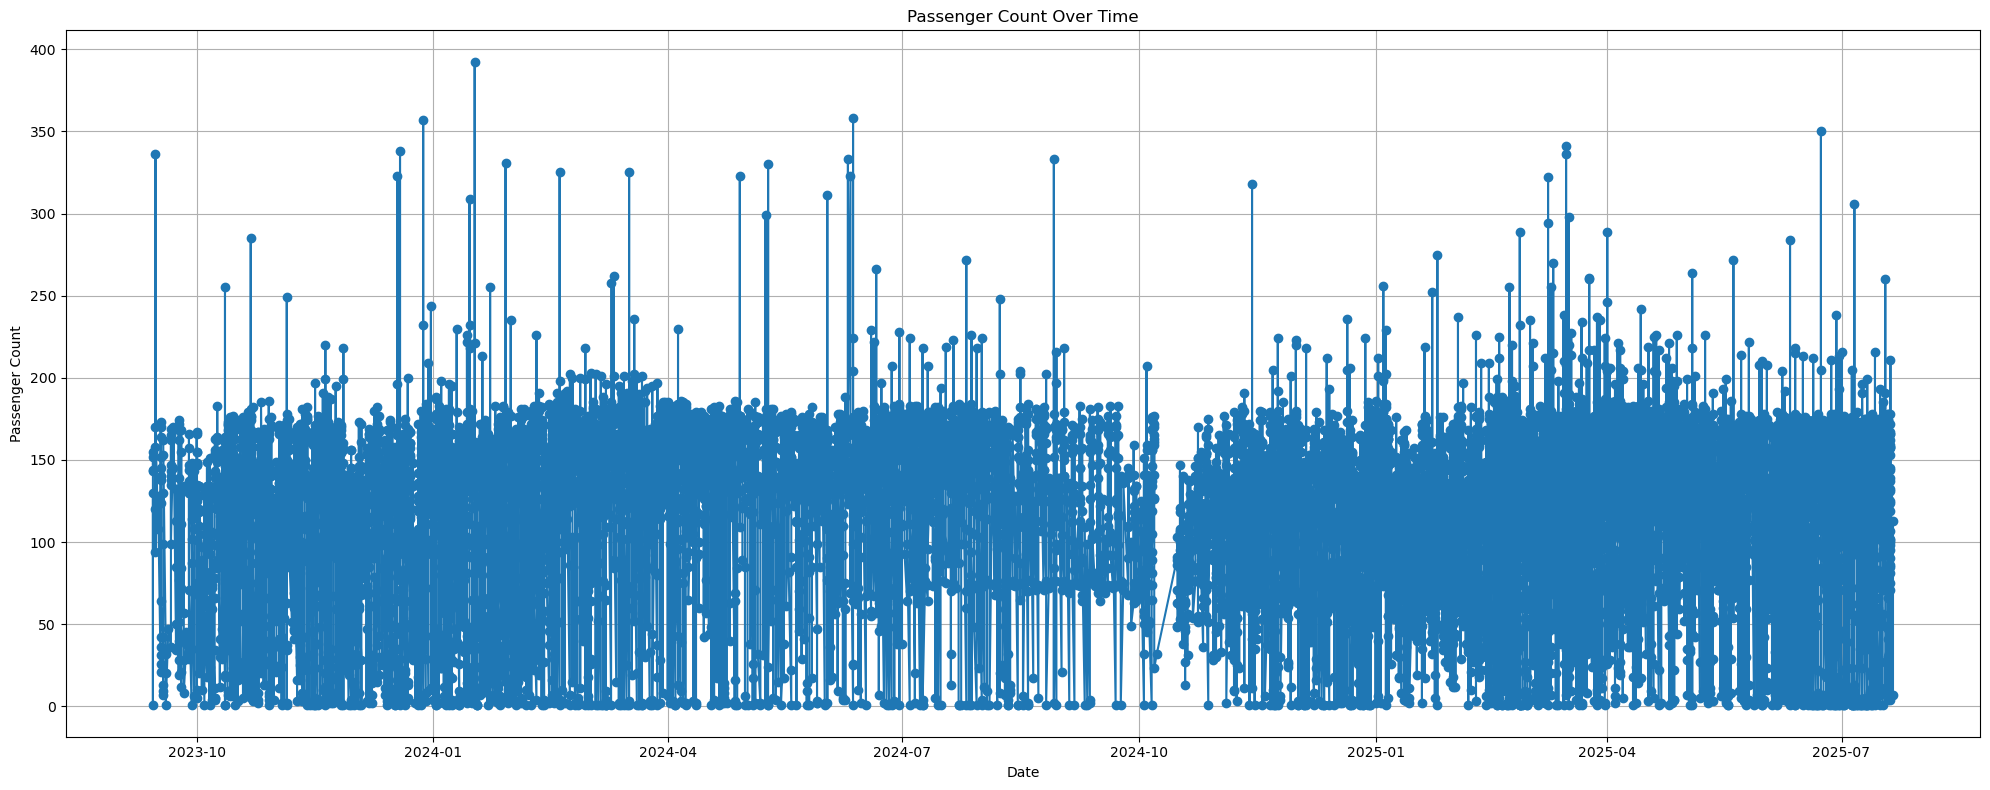

In [5]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], df['Boarded'], marker='o', linestyle='-')
plt.title('Passenger Count Over Time')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Extract time-based features
#df['Hour'] = df['Flight Time'].dt.hour
df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day

# Create time-based categories
#df['Time_Category'] = pd.cut(df['Hour'], 
                           #bins=[0, 6, 12, 18, 24], 
                           #labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Destination Airport', 'Airline']

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Select features for modeling
feature_columns = [
    'Destination Airport_encoded', 
    'Airline_encoded', 'Day_of_Week', 'Month', 
    'Day_of_Month'
]

X = df[feature_columns]
y = df['Boarded']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (13279, 5)
Target shape: (13279,)


In [7]:
#Need to drop time stamps for modeling but need the timestamps to present data
df_timestamps = df['Date']

split_factor = 0.8
split_index = int(len(df) * split_factor)

train_df = df[:split_index]
test_df = df[split_index:]

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=None
# )

# Extract X and y from train and test sets
X_train = train_df[feature_columns]
y_train = train_df['Boarded']

X_test = test_df[feature_columns]
y_test = test_df['Boarded']


print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min()} to {y_train.max()}")
print(f"Testing target range: {y_test.min()} to {y_test.max()}")

Training set size: 10623
Testing set size: 2656
Training target range: 1 to 392
Testing target range: 1 to 350


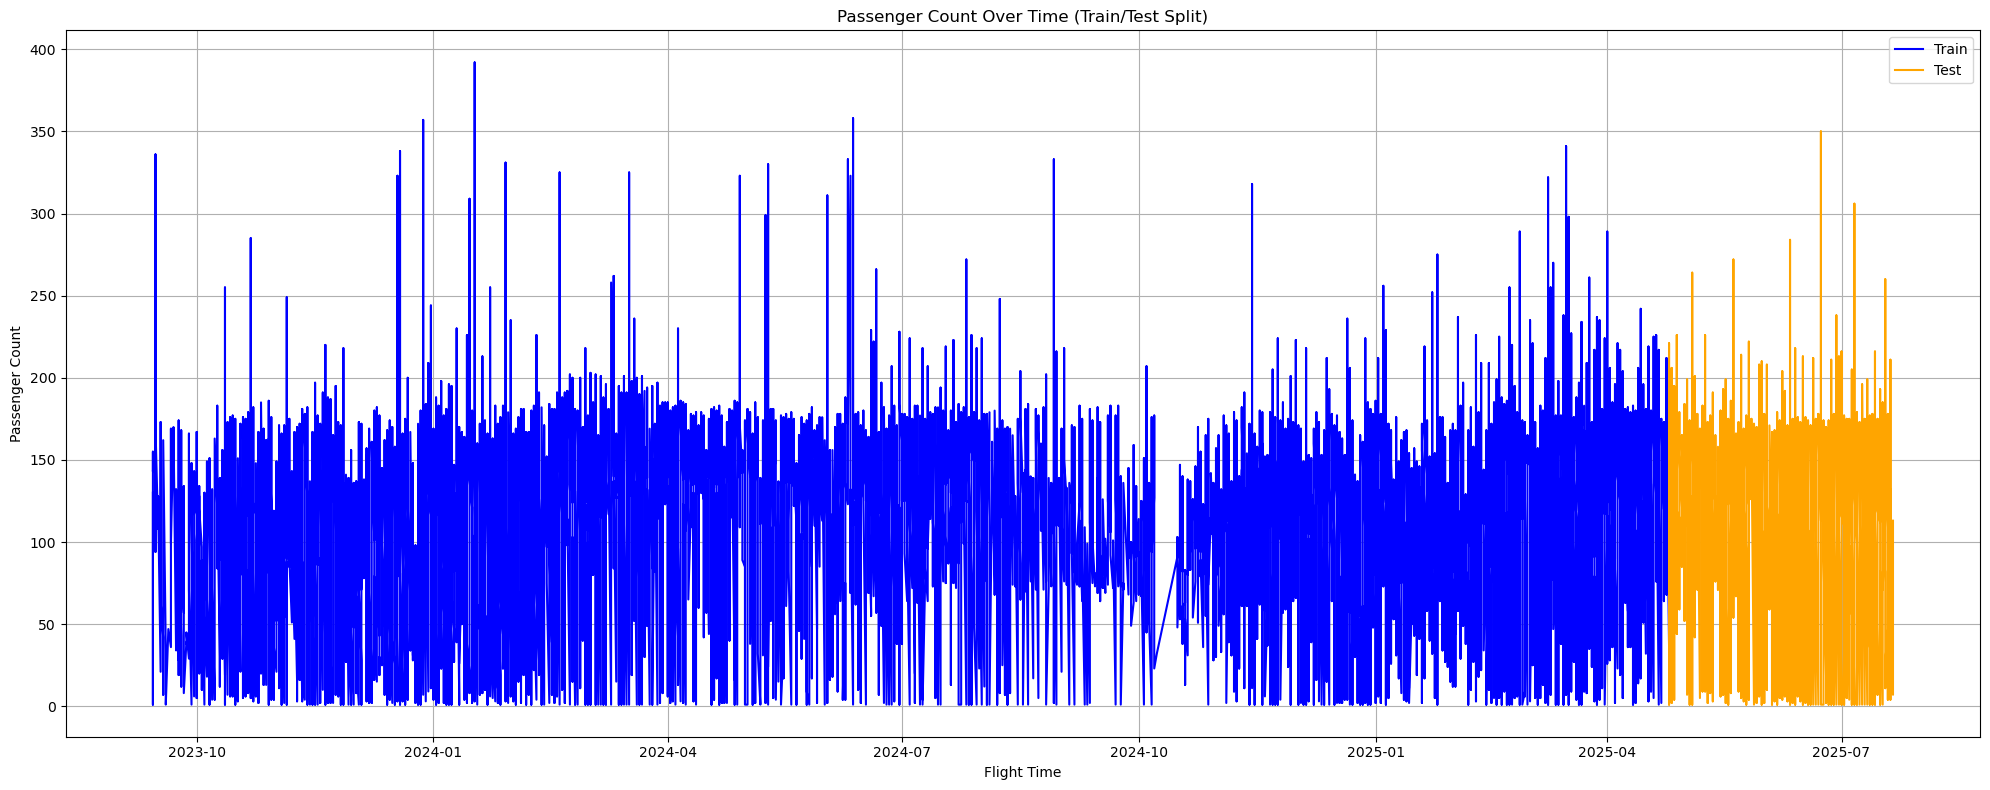

In [8]:
plt.figure(figsize=(20,8))

plt.plot(df_timestamps[:split_index], y_train, label='Train', color='blue')
plt.plot(df_timestamps[split_index:], y_test, label='Test', color='orange')

plt.title('Passenger Count Over Time (Train/Test Split)')
plt.xlabel('Flight Time')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Create and train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Prevent overfitting
    min_samples_split=5,     # Minimum samples to split
    min_samples_leaf=2,      # Minimum samples in leaf
    random_state=42,
    oob_score=True,          # Out-of-bag scoring
    n_jobs=-1               # Use all processors
)

# Train the model
rf_model.fit(X_train, y_train)

print("Model training completed!")
print(f"Out-of-Bag Score: {rf_model.oob_score_:.4f}")

Model training completed!
Out-of-Bag Score: 0.4362


In [10]:
df['Boarded'].min(), df['Boarded'].max()

(1, 392)

In [11]:
# Make predictions on test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
sad_score = np.sum(np.abs(y_test - y_pred))
#GET SAD score

print("Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Out-of-Bag Score: {rf_model.oob_score_:.4f}")

# Context for interpretation
print(f"\nFor context:")
print(f"Average passenger count: {y_test.mean():.1f}")
print(f"Typical prediction error: ±{rmse:.1f} passengers")

Model Performance on Test Set:
Mean Squared Error: 1801.1389
Root Mean Squared Error: 42.4398
Mean Absolute Error: 31.9921
R-squared Score: 0.2800
Out-of-Bag Score: 0.4362

For context:
Average passenger count: 117.6
Typical prediction error: ±42.4 passengers


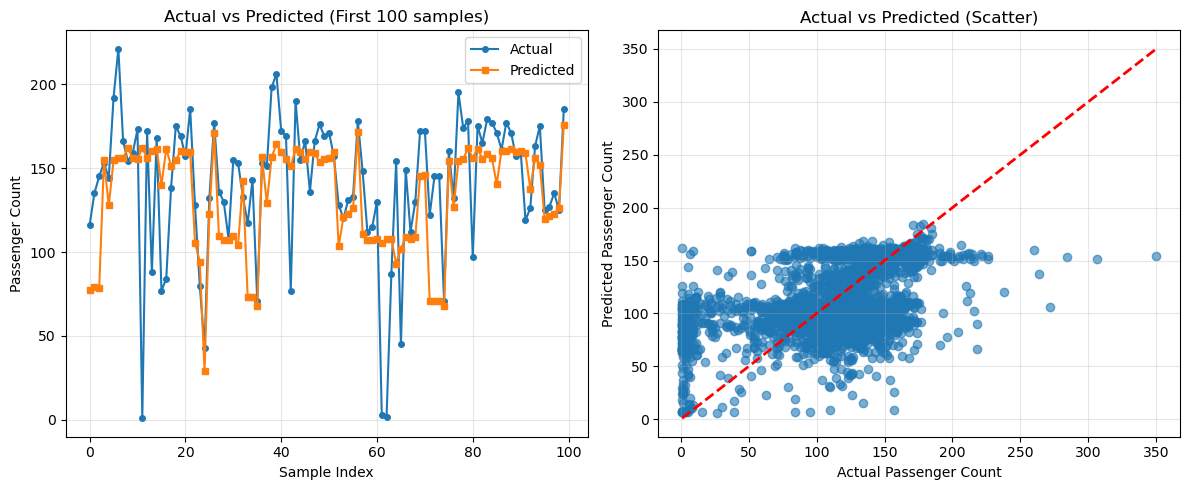

In [12]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))

# Line plot
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual', marker='o', markersize=4)
plt.plot(y_pred[:100], label='Predicted', marker='s', markersize=4)
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted (Scatter)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Importance:
                       feature  importance
1              Airline_encoded    0.565856
3                        Month    0.127015
4                 Day_of_Month    0.121959
0  Destination Airport_encoded    0.115301
2                  Day_of_Week    0.069869


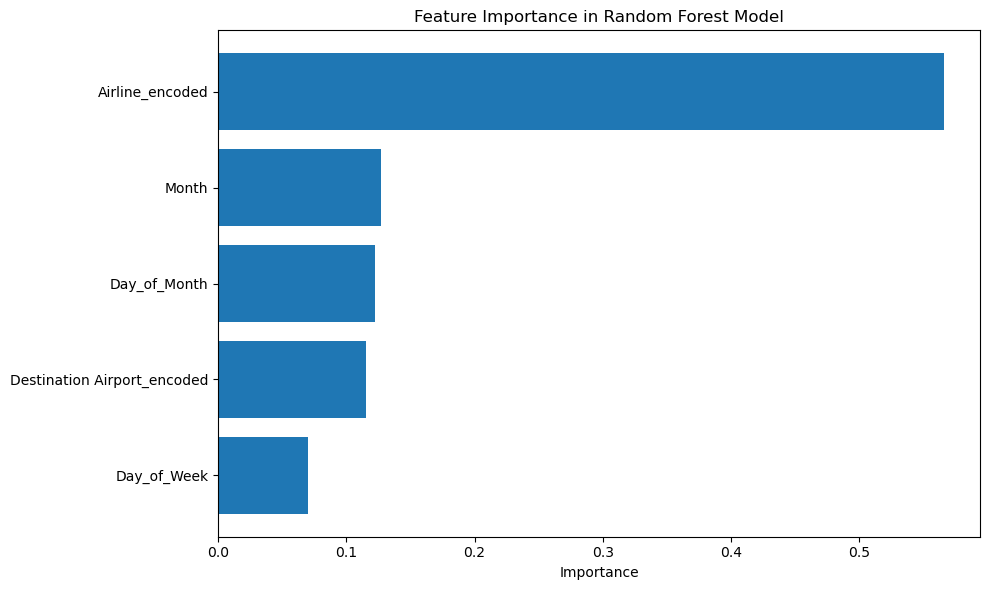

In [13]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
# Example: Predict passenger count for new flights
def predict_passengers(model, flight_time, dest_airport, airline):
    # Create a sample prediction
    sample_data = pd.DataFrame({
        'Flight Time': [flight_time]
    })
    
    # Extract time features
    #sample_data['Hour'] = pd.to_datetime(sample_data['Flight Time']).dt.hour
    sample_data['Day_of_Week'] = pd.to_datetime(sample_data['Flight Time']).dt.dayofweek
    sample_data['Month'] = pd.to_datetime(sample_data['Flight Time']).dt.month
    sample_data['Day_of_Month'] = pd.to_datetime(sample_data['Flight Time']).dt.day
    
    # Encode categorical variables (using saved encoders)
    try:
        #sample_data['Source Airport_encoded'] = label_encoders['Source Airport'].transform([source_airport])[0]
        sample_data['Destination Airport_encoded'] = label_encoders['Destination Airport'].transform([dest_airport])[0]
        sample_data['Airline_encoded'] = label_encoders['Airline'].transform([airline])[0]
        
        # Create time category
        # time_cat = pd.cut(sample_data['Hour'], 
        #                  bins=[0, 6, 12, 18, 24], 
        #                  labels=['Night', 'Morning', 'Afternoon', 'Evening'])[0]
        # sample_data['Time_Category_encoded'] = label_encoders['Time_Category'].transform([time_cat])[0]
        
        # Make prediction
        prediction = model.predict(sample_data[feature_columns])[0]
        return round(prediction)
    
    except ValueError as e:
        return f"Error: Unknown category - {e}"

In [15]:
# Example usage
example_prediction = predict_passengers(
    rf_model,
    '2025-04-29 14:30:00', 
    'STL', 
    'XP'
)
print(f"Predicted passenger count: {example_prediction}")

Predicted passenger count: 113


## hyperparam tuning

In [16]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30,40, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# For faster search, use a smaller randomized grid
param_grid_random = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

## Random Search

In [17]:
rf = RandomForestRegressor()
tscv= TimeSeriesSplit(3)

In [18]:
print("Starting Randomized Search...")
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_random,
    n_iter=100,  # Number of parameter combinations to try
    cv=tscv,
    scoring='neg_mean_squared_error',  # Use 'neg_mean_squared_error' for regression
    n_jobs=-1,
    verbose=1,
    random_state=42
)

Starting Randomized Search...


In [19]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [20]:
# Get the best model
best_rf = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Make predictions
y_pred = best_rf.predict(X_test)

Best parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Best cross-validation score: -1836.1885


In [21]:
# Example usage
example_prediction = predict_passengers(
    best_rf,
    '2025-04-29 14:30:00', 
    'STL', 
    'XP'
)
    
print(f"Predicted passenger count: {example_prediction}")

Predicted passenger count: 112


In [22]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
#print(f"Out-of-Bag Score: {best_rf.oob_score_:.4f}")

# Context for interpretation
print(f"\nFor context:")
print(f"Average passenger count: {y_test.mean():.1f}")
print(f"Typical prediction error: ±{rmse:.1f} passengers")

Model Performance on Test Set:
Mean Squared Error: 1747.7727
Root Mean Squared Error: 41.8064
Mean Absolute Error: 31.8062
R-squared Score: 0.3014

For context:
Average passenger count: 117.6
Typical prediction error: ±41.8 passengers


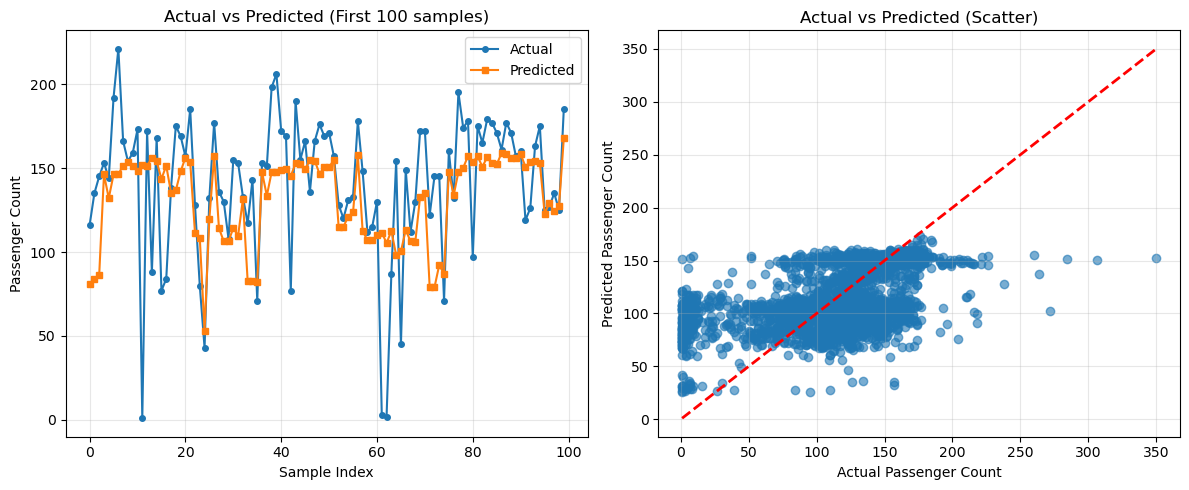

In [23]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))

# Line plot
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual', marker='o', markersize=4)
plt.plot(y_pred[:100], label='Predicted', marker='s', markersize=4)
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted (Scatter)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Importance:
                       feature  importance
1              Airline_encoded    0.565856
3                        Month    0.127015
4                 Day_of_Month    0.121959
0  Destination Airport_encoded    0.115301
2                  Day_of_Week    0.069869


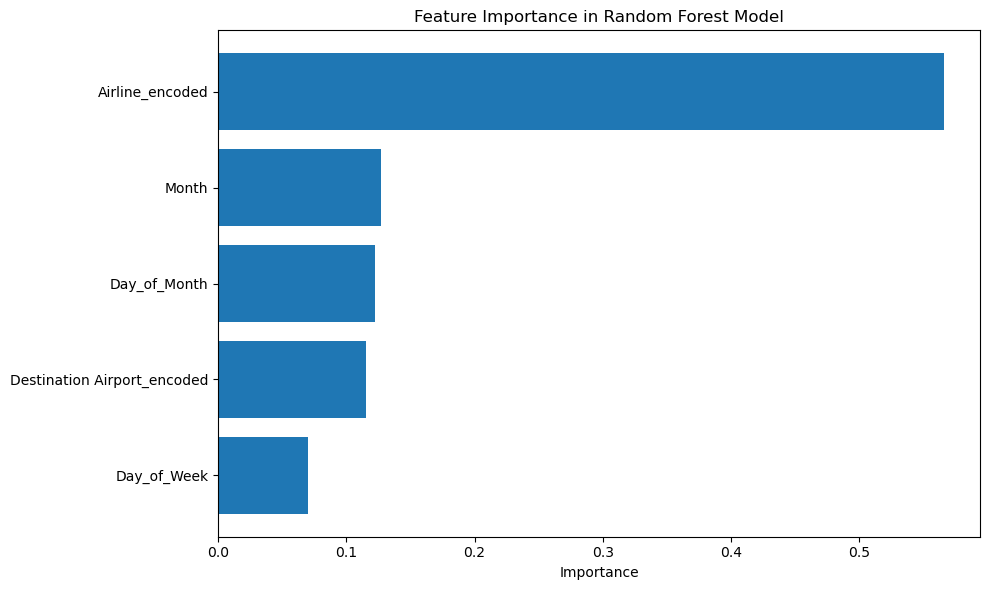

In [24]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

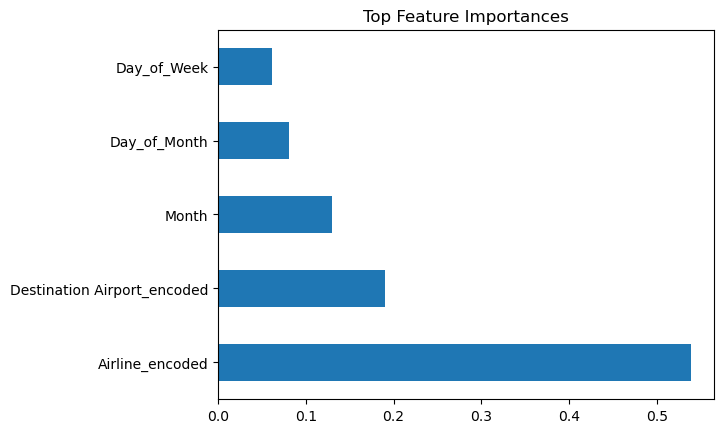

In [25]:
importances = random_search.best_estimator_.feature_importances_
features = X.columns if hasattr(X, 'columns') else [f'feat_{i}' for i in range(X.shape[1])]
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

feat_imp.head(20).plot(kind='barh')
plt.title("Top Feature Importances")
plt.show()

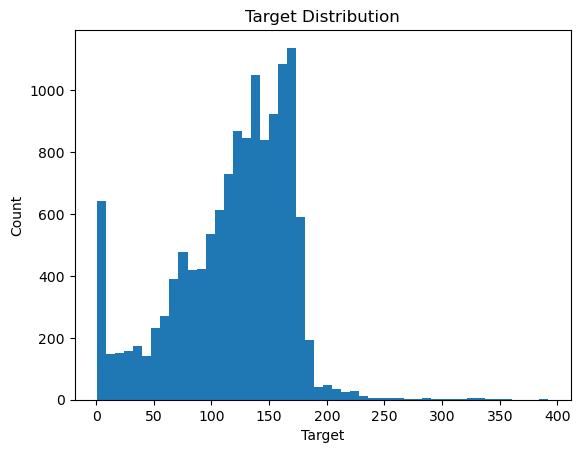

In [26]:
plt.hist(y, bins=50)
plt.title("Target Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

## grid search

In [27]:
print("Starting Grid Search...")
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  
    n_jobs=-1,  # Use all available cores if any
    verbose=1
)

Starting Grid Search...


In [28]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits



KeyboardInterrupt



In [ ]:
best_gs_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Make predictions
y_pred = best_gs_rf.predict(X_test)

In [ ]:
# Example usage
example_prediction = predict_passengers(
    best_gs_rf,
    '2025-04-29 14:30:00', 
    'STL', 
    'XP'
)
print(f"Predicted passenger count: {example_prediction}")

In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
#print(f"Out-of-Bag Score: {best_gs_rf.oob_score_:.4f}")

# Context for interpretation
print(f"\nFor context:")
print(f"Average passenger count: {y_test.mean():.1f}")
print(f"Typical prediction error: ±{rmse:.1f} passengers")

In [ ]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_gs_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()